<a href="https://colab.research.google.com/github/jeniferwerthman/AdvAILSTM/blob/main/Copy_of_LSTMStock_Take2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip install -q yfinance

In [61]:
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader.data import DataReader

import yfinance as yf

import matplotlib.pyplot as mplot
from matplotlib.ticker import MultipleLocator
import matplotlib.dates as mdates

import numpy as np 

from datetime import datetime as dt
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [62]:
#Import Data 
stockTypes = ['TSLA','AAPL', 'GOOG', 'MSFT', 'AMZN', 'DELL']

#Import from API
end = dt.now()
start = dt(end.year - 4, end.month, end.day)
for stockDf in stockTypes:
    globals()[stockDf] = yf.download(stockDf, start, end)

#Add Name
stocks = [TSLA, AAPL, GOOG, MSFT, AMZN, DELL]
company_name = ["TESLA", "APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "DELL"]

for stock, name in zip(stocks, company_name):
    stock["company_name"] = name

#Additional Columns
for stock in stocks:
    stock['openChange'] = stock.Open.pct_change()
    stock['closeChange'] = stock.Close.pct_change()

# Select features (columns) to be involved intro training and predictions
cols = list(stocks[1])[0:1]
#cols.pop(1) #Delete middle column

print('Training set shape == {}'.format(stocks[1].shape))
print('Featured selected: {}'.format(cols))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Training set shape == (1007, 9)
Featured selected: ['Open']


In [63]:
DELL.head()

,Open,High,Low,Close,Adj Close,Volume,company_name,openChange,closeChange
Date,,,,,,,,,
2018-05-03,19.863955,20.015503,19.400892,19.981827,19.842831,5001005,DELL,NaN,NaN
2018-05-04,19.889214,20.641338,19.807825,20.472952,20.330540,2996327,DELL,0.001272,0.024579
2018-05-07,20.486984,20.795692,20.293341,20.343857,20.202341,2057770,DELL,0.030055,-0.006306
2018-05-08,20.352276,20.352276,19.936922,20.209146,20.068569,5340225,DELL,-0.006575,-0.006622
2018-05-09,20.284922,20.669401,20.225985,20.408403,20.266439,5428237,DELL,-0.003309,0.009860


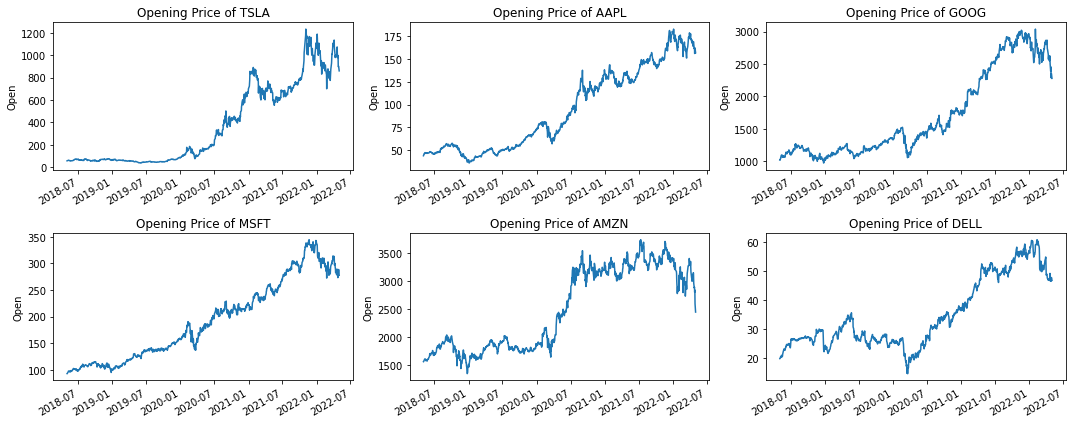

In [64]:
#Opening Graph
mplot.figure(figsize=(15, 6))
mplot.subplots_adjust(top=1.25, bottom=1)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Open'].plot()
    mplot.ylabel('Open')
    mplot.xlabel(None)
    mplot.title(f"Opening Price of {stockTypes[i - 1]}")
    
mplot.tight_layout()

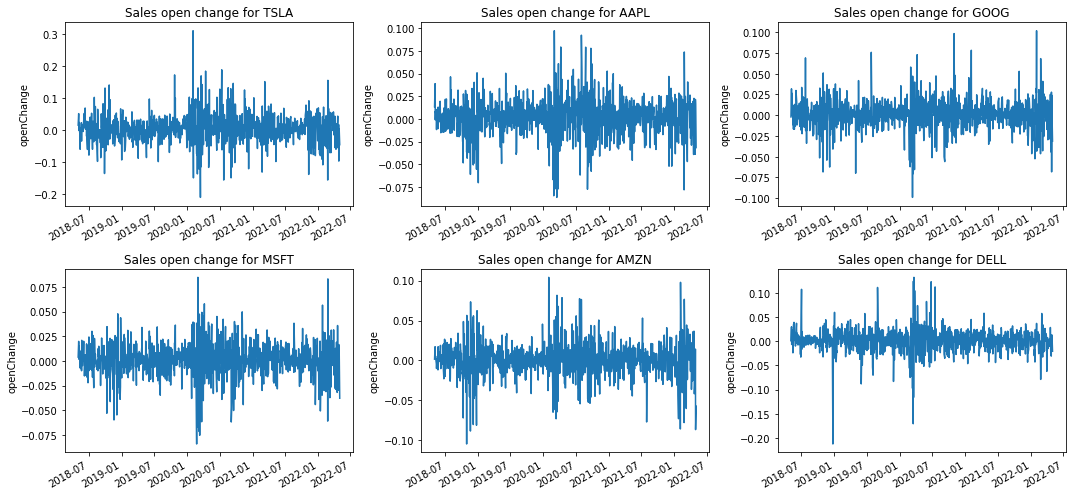

In [65]:
#Change Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['openChange'].plot()
    mplot.ylabel('openChange')
    mplot.xlabel(None)
    mplot.title(f"Sales open change for {stockTypes[i - 1]}")
    
mplot.tight_layout()

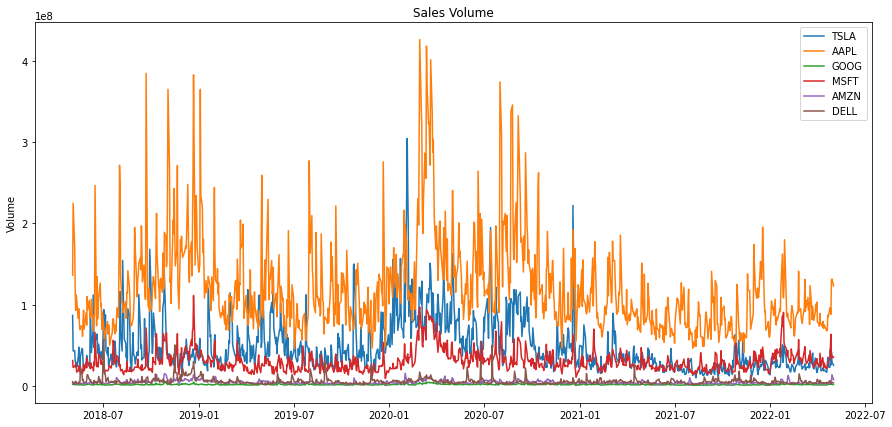

In [66]:
mplot.figure(figsize=(15, 7))
mplot.title(f"Sales Volume")
for i, stock in enumerate(stocks, 1):
  mplot.plot(stock['Volume'], label = stockTypes[i - 1]) 
  
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show()  

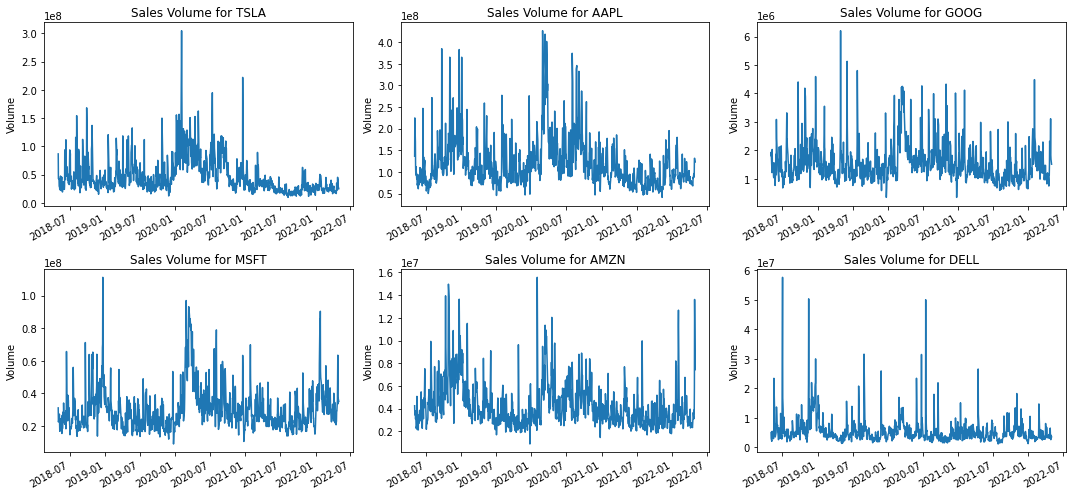

In [67]:
#Volume Graphs

mplot.figure(figsize=(15, 7))
mplot.subplots_adjust(top=1.25, bottom=1.2)

for i, stock in enumerate(stocks, 1):
    mplot.subplot(2, 3, i)
    stock['Volume'].plot()
    mplot.ylabel('Volume')
    mplot.xlabel(None)
    mplot.title(f"Sales Volume for {stockTypes[i - 1]}")
    
mplot.tight_layout()

In [68]:
DELL.head(10)

,Open,High,Low,Close,Adj Close,Volume,company_name,openChange,closeChange
Date,,,,,,,,,
2018-05-03,19.863955,20.015503,19.400892,19.981827,19.842831,5001005,DELL,NaN,NaN
2018-05-04,19.889214,20.641338,19.807825,20.472952,20.330540,2996327,DELL,0.001272,0.024579
2018-05-07,20.486984,20.795692,20.293341,20.343857,20.202341,2057770,DELL,0.030055,-0.006306
2018-05-08,20.352276,20.352276,19.936922,20.209146,20.068569,5340225,DELL,-0.006575,-0.006622
2018-05-09,20.284922,20.669401,20.225985,20.408403,20.266439,5428237,DELL,-0.003309,0.009860
2018-05-10,20.461725,21.163336,20.447695,20.961271,20.815462,4681738,DELL,0.008716,0.027090
2018-05-11,20.950047,20.958466,20.725531,20.857433,20.712345,3411800,DELL,0.023865,-0.004954
2018-05-14,20.961271,21.062304,20.489790,20.672209,20.528410,3034810,DELL,0.000536,-0.008881
2018-05-15,20.461725,20.840595,20.355082,20.745176,20.600870,3116764,DELL,-0.023832,0.003530


In [76]:
#Get Desired columns to train
stockDf = stocks[1]
print('Featured selected: {}'.format(cols))
stockDf = stockDf[cols].astype(str)
for i in cols:
    for j in range(0, len(stockDf)):
        stockDf[i][j] = stockDf[i][j].replace(',', '')

stockDf = stockDf.astype(float)

# Using multiple features (predictors) 
fromRecord = 50
toRecord = 100
newDf = stockDf[fromRecord:toRecord]
myDs = newDf.to_numpy() 
myDs = myDs.astype('float32')
print('Shape of training set == {}.'.format(newDf.shape))
newDf[1:5]

Featured selected: ['Open']
Shape of training set == (50, 1).


,Open
Date,
2018-07-17,47.437500
2018-07-18,47.945000
2018-07-19,47.422501
2018-07-20,47.945000


In [77]:
#Parameters
trainingSet = .70
featureRange1 = 0
featureRange2 = 1
newShape1 = -1
newShape2 = 1 

myDs = np.reshape(myDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
myDs = scaler.fit_transform(myDs)
trainingSize = int(len(myDs) * trainingSet)
testingSize = int(len(myDs) - trainingSize)
trainData, testData = myDs[0:trainingSize,:], myDs[testingSize:len(myDs),:]


In [78]:
#Parameters
batchSize = 5
timeSteps = 1
#Batch Data for optimization and accuracy
#This creates batches with 1 to N records.  
#X - Each Batch starts with the next item i in the list and contains specified number of additional items
#Y - Contains the last item in each batch "L" or first "F" or previious "P" or next "N"
def batchData(data, size, indexAlignment = "L"):
    X, Y = [], [] 
    for i in range(len(data) - size - 1): 
        X.append(data[i:(i + size), 0])
         
        if indexAlignment == "N":
          Y.append(data[i + size, 0])
        elif indexAlignment == "L":
          Y.append(data[i + size - 1, 0])
        elif indexAlignment == "P":  
          Y.append(data[i-1, 0])
        else:
          Y.append(data[i, 0]) 

    return np.array(X), np.array(Y)

#Catch Batches for Accuracy and Optimization
X_train, Y_train = batchData(trainData, batchSize, "L")
X_test, Y_test = batchData(testData, batchSize,"L")

#Reshape data to normalize it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], timeSteps, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], timeSteps, X_test.shape[1]))

In [79]:
#Parameters
verboseAmt = 1
epochCnt = 100
shuffleData = False
dropOut = 0.2
lstmActivation = 'relu'
activationLayer = 'linear'
lossType = 'mean_squared_error'
optimizerType = 'adam'
lstmUnits = 50
lstmMultipleLayers = True

model = Sequential()

if lstmMultipleLayers:
  model.add(LSTM(units = lstmUnits, return_sequences = True, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize)))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits, return_sequences = True))
  model.add(Dropout(dropOut))

  model.add(LSTM(units = lstmUnits))
  model.add(Dropout(dropOut))
else:
  model.add(LSTM(units = lstmUnits, activation = lstmActivation, input_shape = (X_train.shape[1], batchSize))) 
  model.add(Dropout(dropOut))

model.add(Dense(1, activation = activationLayer))
model.compile(loss = lossType, optimizer = optimizerType)
modelFit = model.fit(X_train, Y_train, epochs = epochCnt, batch_size = batchSize, validation_data = (X_test, Y_test), verbose = verboseAmt, shuffle = False)
model.summary()

Epoch 1/100
6/6 [==============================] - 8s 272ms/step - loss: 0.2259 - val_loss: 0.5397
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2094 - val_loss: 0.5073
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1904 - val_loss: 0.4694
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1694 - val_loss: 0.4235
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.1438 - val_loss: 0.3666
Epoch 6/100
6/6 [==============================] - 0s 12ms/step - loss: 0.1159 - val_loss: 0.2953
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0869 - val_loss: 0.2093
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.0540 - val_loss: 0.1179
Epoch 9/100
6/6 [==============================] - 0s 13ms/step - loss: 0.0325 - val_loss: 0.0424
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 0.0295 - val_loss: 0.0104
Epoch 11/100
6/6 [

In [80]:
#Predictions
train_predict = model.predict(X_train)
Y_trained_predict = scaler.inverse_transform(train_predict)

test_predict = model.predict(X_test)
Y_test_predict = scaler.inverse_transform(test_predict)

Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train]) 

In [81]:
print('X_train: ' + str(len(X_train)))
print('X_test: ' + str(len(X_test)))
print('Y_train: ' + str(len(Y_train)))
print('Y_test: ' + str(len(Y_test)))
print('X Train Shape' + str(X_train.shape))
print('Y Train Shape' + str(Y_train.shape))
print('X Test Shape' + str(X_test.shape))
print('Y Test Shape' + str(Y_test.shape))
print('train_predict: ' + str(len(train_predict)))
print('Y_trained_predict: ' + str(len(Y_trained_predict)))
print('test_predict: ' + str(len(test_predict)))
print('Y_test_predict: ' + str(len(Y_test_predict)))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:' + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))
print('Shape of Y_train:'  + str(Y_train.shape[0]))

X_train: 29
X_test: 29
Y_train: 1
Y_test: 1
X Train Shape(29, 1, 5)
Y Train Shape(1, 29)
X Test Shape(29, 1, 5)
Y Test Shape(1, 29)
train_predict: 29
Y_trained_predict: 29
test_predict: 29
Y_test_predict: 29
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1
Shape of Y_train:1


In [82]:
#inverse the inverse
Y_trained_predict = scaler.inverse_transform(train_predict)
Y_test_predict = scaler.inverse_transform(test_predict)

s1 = Y_test.shape[0]
s2 = Y_test.shape[1]
Y_test = Y_test.reshape(s2,s1)
s1 = Y_train.shape[0]
s2 = Y_train.shape[1]
Y_train = Y_train.reshape(s2,s1)

In [83]:
#Calculate Accuracy
train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_trained_predict))
test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_test_predict))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
0.47542479286072953 

Test RMSE is: 
0.5583281630079016


In [84]:
#Actual vs Predicted Data
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_trained_predict, Y_test_predict)
result_df = pd.DataFrame()
result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat
result_df.head()

,Actual_Y,Predicted_Y
0,47.944999,48.281349
1,47.669999,48.241764
2,48.112499,48.382347
3,48.264998,48.503170
4,48.652502,48.748596


Text(0, 0.5, 'Value of Stock')

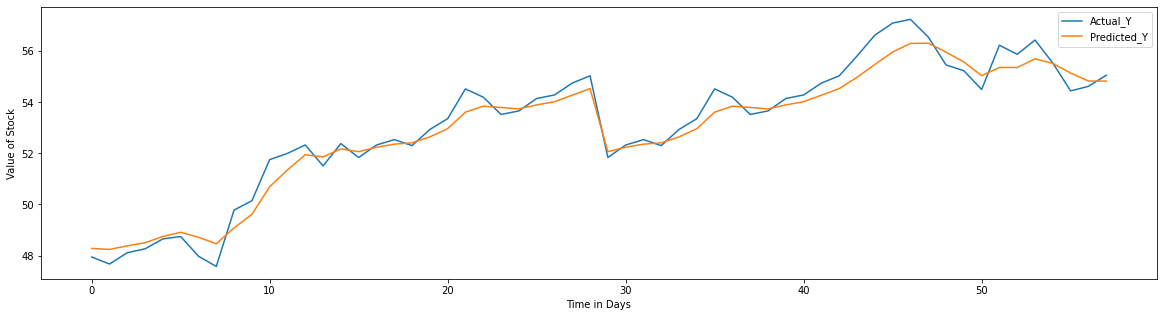

In [85]:
#Actual vs Predicted Graph
result_df.plot(figsize=(20,5))
mplot.xlabel('Time in Days')
mplot.ylabel('Value of Stock')

In [ ]:
#Prediction Forcastings
predictionCount = 9
lookback =15
datelist_future = pd.date_range(end, periods=predictionCount, freq='1d').tolist() 

#date calculation for past
n_days_ago = end - timedelta(days=lookback)
datelist_past = pd.date_range(n_days_ago, periods=lookback, freq='1d').tolist()

print(datelist_past)

predictMeData = stockDf[-lookback:] 
predictionDs = predictMeData.to_numpy() 
predictionDs = predictionDs.astype('float32')

predictionDs = np.reshape(predictionDs, (newShape1, newShape2))
scaler = MinMaxScaler(feature_range=(featureRange1, featureRange2))
predictionDs = scaler.fit_transform(predictionDs)  
X = predictionDs[0:lookback,:] 

XX, YY = batchData(X, batchSize, "L")
XX = np.reshape(XX, (XX.shape[0], timeSteps, XX.shape[1]))
out = model.predict(XX)

Y_out = scaler.inverse_transform(out) 
 
#New code for future prediction
y_past_predict = model.predict(X_train[lookback-1:])
y_past_train = scaler.inverse_transform(y_past_predict)
#print(y_past_train)

y_future_predict = model.predict(X_train[-predictionCount:])
y_future_train = scaler.inverse_transform(y_future_predict)
#print(y_future_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_future_train, columns=['Open']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_past_train, columns=['Open']).set_index(pd.Series(datelist_past))
print(PREDICTIONS_FUTURE)
print(PREDICTION_TRAIN)
PREDICTIONS_FUTURE.head(11)

[Timestamp('2022-04-17 01:09:18.820334', freq='D'), Timestamp('2022-04-18 01:09:18.820334', freq='D'), Timestamp('2022-04-19 01:09:18.820334', freq='D'), Timestamp('2022-04-20 01:09:18.820334', freq='D'), Timestamp('2022-04-21 01:09:18.820334', freq='D'), Timestamp('2022-04-22 01:09:18.820334', freq='D'), Timestamp('2022-04-23 01:09:18.820334', freq='D'), Timestamp('2022-04-24 01:09:18.820334', freq='D'), Timestamp('2022-04-25 01:09:18.820334', freq='D'), Timestamp('2022-04-26 01:09:18.820334', freq='D'), Timestamp('2022-04-27 01:09:18.820334', freq='D'), Timestamp('2022-04-28 01:09:18.820334', freq='D'), Timestamp('2022-04-29 01:09:18.820334', freq='D'), Timestamp('2022-04-30 01:09:18.820334', freq='D'), Timestamp('2022-05-01 01:09:18.820334', freq='D')]
                                  Open
2022-05-02 01:09:18.820334  164.489380
2022-05-03 01:09:18.820334  165.036423
2022-05-04 01:09:18.820334  165.936050
2022-05-05 01:09:18.820334  166.397430
2022-05-06 01:09:18.820334  166.355194


,Open
2022-05-02 01:09:18.820334,164.489380
2022-05-03 01:09:18.820334,165.036423
2022-05-04 01:09:18.820334,165.936050
2022-05-05 01:09:18.820334,166.397430
2022-05-06 01:09:18.820334,166.355194
2022-05-07 01:09:18.820334,166.382263
2022-05-08 01:09:18.820334,166.683502
2022-05-09 01:09:18.820334,166.794220
2022-05-10 01:09:18.820334,167.099228


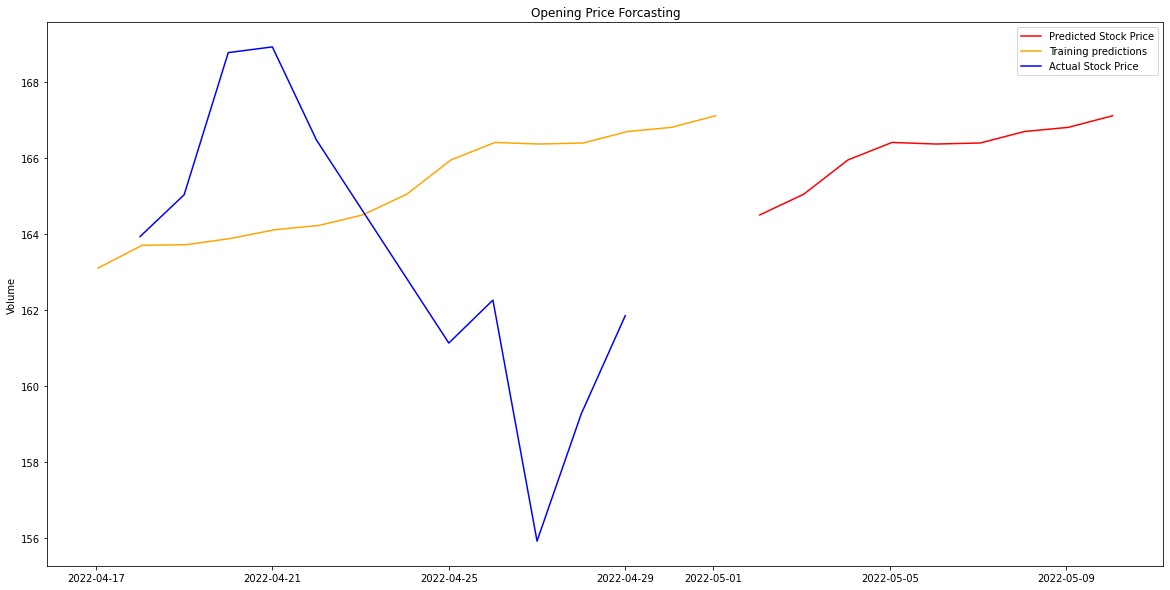

In [ ]:
mplot.figure(figsize=(20,10))
mplot.title(f"Opening Price Forcasting")
mplot.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Open'], color='r', label='Predicted Stock Price')
mplot.plot(PREDICTION_TRAIN.loc[n_days_ago:].index, PREDICTION_TRAIN.loc[n_days_ago:]['Open'], color='orange', label='Training predictions')
mplot.plot(stockDf.loc[n_days_ago:].index, stockDf.loc[n_days_ago:]['Open'], color='b', label='Actual Stock Price')
mplot.ylabel('Volume')
mplot.xlabel(None)
mplot.legend()
mplot.show() 